<a href="https://colab.research.google.com/github/guiraposo/PINNs_Core/blob/main/Simple_Examples/Waves_on_Strings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook we will see:
1. How to use PINNs to solve differential equations, including ODEs, PDEs and eigenvalue problems.<br>Original paper:<br>

 - Maziar Raissi, Paris Perdikaris, George Em Karniadakis, <i>Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations</i>, Journal of Computational Physics, 378, 686-707, 2019. https://arxiv.org/abs/1711.10561

We will apply it to the study different types of differential equations. Notebook based on the strong gravity lectures of Raimon Luna (cf.  [MachineLearningForStrongGravity](https://github.com/raimonluna/) )

In [ ]:
import numpy as np
import sympy as sp

#Torch libraries
import torch
import torch.nn as nn
import torch.optim as optim

#Plots and Graphic libraries
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.gridspec as gridspec
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

# Example 1: System of Coupled Ordinary Differential Equations (ODEs)

Here we solve the system of ODEs for the sine and cosine functions.

$$s'(x) = c(x),$$
$$c'(x) = -s(x),$$

As expected the solutions are of the form $c(x)=A\cos(x + \psi)$ and $s(x)=A\sin(x + \psi)$.

Let us set the initial conditions as in order to fix the phase and amplitude.

$$s(0) = 0, \;c(0) = 1.$$
<br>


In [ ]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        # Let's apply a simple ANN with 1 hidden layer. Use GELU activation function
        self.net = nn.Sequential(
            nn.Linear(1, 40), # 1 input -> independent variable x
            nn.GELU(),
            nn.Linear(40, 40),  # hidden layer
            nn.GELU(),
            nn.Linear(40, 2), # 2 outputs -> function c(x) and s(x)
        )

        # Initialization of weights and bias
        for layer in self.net.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean = 0, std = 0.1)
                nn.init.constant_(layer.bias, val = 0.0) # standard initialization

    def forward(self, x):
        return self.net(x)

# Define class to compute the ODE loss.
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x):

        f  = self.ode(x)  # Get the approximate solutions

        # Get the approximate solutions for c(x) and s(x)
        c, s = map(lambda i:  f[:,[i]], range(2))

        # Compute the gradients
        dcdx = gradients(c, x)  # c'(x)
        dsdx = gradients(s, x)  # s'(x)

        # Differential Equation Loss:
        # Should be 0 for a solution of the eqs.
        eq_loss = torch.mean((dcdx + s)**2 + (dsdx - c)**2)

        # Initial Condition Loss:
        # We impose the boundary conditions on the equations.
        zero_vals = self.ode(torch.zeros(1,1))
        ic_loss = (zero_vals[0,0] - 1)**2 + zero_vals[0,1]**2

        return eq_loss, ic_loss


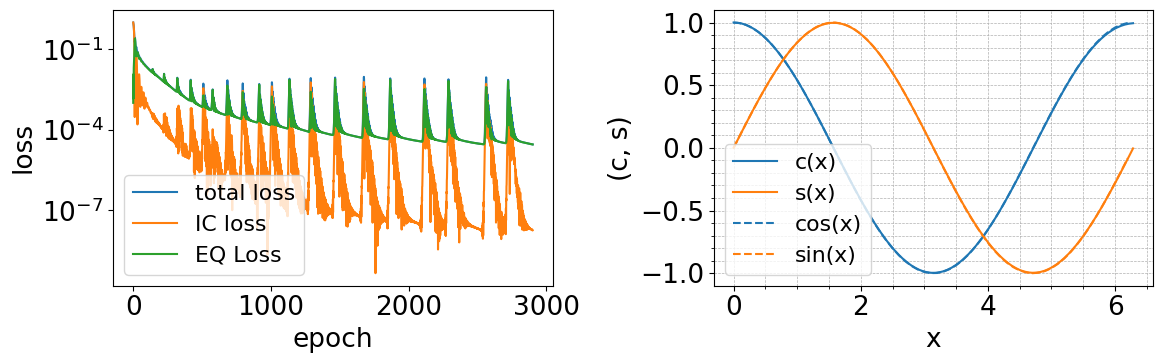

In [ ]:
ode = ODE()  # Initializes the NN class.
odeloss = ODELoss(ode)  # Intitalizes the loss class.


optimizer = optim.Adam(ode.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/2000))

x = torch.tensor(np.linspace(0, 2 * np.pi, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

x_range = np.arange(0, 2*np.pi, 0.1)
c_true = np.cos(x_range)
s_true = np.sin(x_range)




################## Training and Plotting ##################

# Array for saving the loss values
loss_hist = []  # Total loss
ic_loss_hist = []  # Boundary condition loss
eq_loss_hist = []  # ODE loss

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(3000):
    try:
        optimizer.zero_grad()

        eq_loss, ic_loss = odeloss(x)
        loss = eq_loss + ic_loss
        loss.backward()
        optimizer.step()

        #scheduler.step()
        loss_hist.append(loss.item())
        ic_loss_hist.append(ic_loss.item())
        eq_loss_hist.append(eq_loss.item())

        if epoch % 100 == 0:

            # Visualization for the Loss
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            ax1.plot(ic_loss_hist)
            ax1.plot(eq_loss_hist)
            ax1.legend(["total loss","IC loss", "EQ Loss"], fontsize='small')

            # Visualization for the solutions
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('(c, s)')
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 0].cpu().detach().numpy())
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 1].cpu().detach().numpy())
            ax2.plot(x_range, c_true, color='#1f77b4', linestyle = '--') #Plot for the exact solution of cosine
            ax2.plot(x_range, s_true, color = '#ff7f0e', linestyle = '--') #Plot for the exact solution of sine

            ax2.legend(["c(x)","s(x)", "cos(x)", "sin(x)"], fontsize='small')
            plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

            plt.minorticks_on()


            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()

    except KeyboardInterrupt:
        break


As expected the output of the neural network for $c(x)$ and $s(x)$ represent the cosine and the sine.

 The loss function decreases and is low, validating also the method. Just by looking at the plot on the right one can see that the solutions of the PINN (solid lines) approximate very well the exact solutions (dashed lines).

 Let us now repeat the exercise but impose the boundary conditions using strong-enforcement. (TBD)


# Simple Eigenvalue Problem: Vibrating String

Let us consider the case of a oscillating string. The equation that governs waves on strings is given by (we set $c=1$ for simplicity):

$$-\frac{\partial^2 \Psi(t,x)}{\partial t^2} +\frac{\partial^2 \Psi(t,x)}{\partial x^2}=0 $$.

Instead of solving the full partial differential equation (PDE), it is often useful to look at the frequency-domain by taking the fourier decomposition of the function.

$$ $$

By doing this transformation our single PDE reduces to a system of infinite (but separable) ordinary differential equations (ODEs).

$$\psi''(x) + \lambda^2 \psi(x) = 0$$

One option is to provide a value of $\lambda$ and solve the equation. Another option is to impose boundary conditions and reduce this equation to an eigenvalue problem.


Here we want to apply NNs to solve the eigenvalue problem


$$\psi''(x) + \lambda^2 \psi(x) = 0, \quad {\rm with} \quad \psi(0) = \psi(1) = 0.$$

Let us start by checking what we expect the solution to be:
<br>

In [ ]:
psi = sp.Function('psi')
x = sp.symbols('x')
lam = sp.symbols('lam')

In [ ]:
diff_eq1 = sp.Eq(psi(x).diff(x).diff(x) , - lam ** 2 * psi(x))

solution = sp.dsolve(diff_eq1, psi(x))
print(solution)



Eq(psi(x), C1*exp(-I*lam*x) + C2*exp(I*lam*x))


In [ ]:
C1, C2 = sp.symbols('C1 C2')
general_solution = solution.rhs  # Get the right-hand side of the solution


In [ ]:
# Apply the first boundary condition f(0) = 0
bc1 = general_solution.subs(x, 0).subs(psi(0), 0)
solutions = sp.solve((bc1), (C2), dict=True)
print(solutions)
replaced_solution = general_solution.subs(C2,-C1) #This is the solution with the boundary condition at x=0 satisfied
print(replaced_solution)


[{C2: -C1}]
-C1*exp(I*lam*x) + C1*exp(-I*lam*x)


We can easily see the expression at x=1:

In [ ]:
replaced_solution.subs(x,1)

-C1*exp(I*lam) + C1*exp(-I*lam)

It is easy to see that this boundary condition is only satisfied when

$$\lambda = n \times \pi, $$
and $n$ is an integer number.

Our neural network should find sinusoidal solutions with this eigenvalue.

In [ ]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.lam = nn.Parameter(torch.tensor(7., requires_grad=True))  # Adjusted for the first overtone

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 1),
        ) # 1 hidden layer is enough

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.3)
                nn.init.constant_(m.bias, val = 0)

    def forward(self, x):
        return self.net(x) * x * (1 - x) #This is another way to force the boundary conditions
def node_penalty(f, expected_sign_changes=1):

    # Calculate the sign of f at each point
    sign_f = torch.sign(f)

    # Calculate the difference in sign between consecutive elements
    # A non-zero difference indicates a sign change
    product_consecutive = f[1:] * f[:-1] #If the product of two consecutive numbers is negative, it means that the sign changed. (if the function is oscillating around 0)

    sign_changes =  (product_consecutive < 0).float()



    # Count the number of sign changes (non-zero entries imply a sign change)
    num_sign_changes = torch.sum(sign_changes).float()

    # Calculate the penalty as the squared difference between the observed and expected sign changes
    penalty = (((num_sign_changes - expected_sign_changes) ** 2))/(expected_sign_changes + num_sign_changes+0.001) ** 2

    return penalty, num_sign_changes

def amplitude_regularization(f, target_amplitude):
    # Calculate the deviation of f's peak (or average) amplitude from the target
    amplitude_deviation = torch.abs(torch.max(torch.abs(f)) - target_amplitude)
    return amplitude_deviation**2

class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x):
        f  = self.ode(x)
        d2f = gradients(f, x, 2)
        base_loss = torch.mean((d2f + f*self.ode.lam**2)**2)
        #regularization = torch.mean(torch.abs(f) - 1)**2
        regularization = torch.tensor(0)
        # Node penalty encouraging the presence of a node (zero crossing)
        node_penalty_term , num_sign_changes_term = node_penalty(f)
        amplitude_loss = amplitude_regularization(f,1)
        loss = base_loss + 1*regularization  +  node_penalty_term + amplitude_loss
      #  loss = torch.mean((d2f + f*self.ode.lam**2)**2+ (torch.mean(f) )**2)

        return loss, node_penalty_term, num_sign_changes_term, regularization

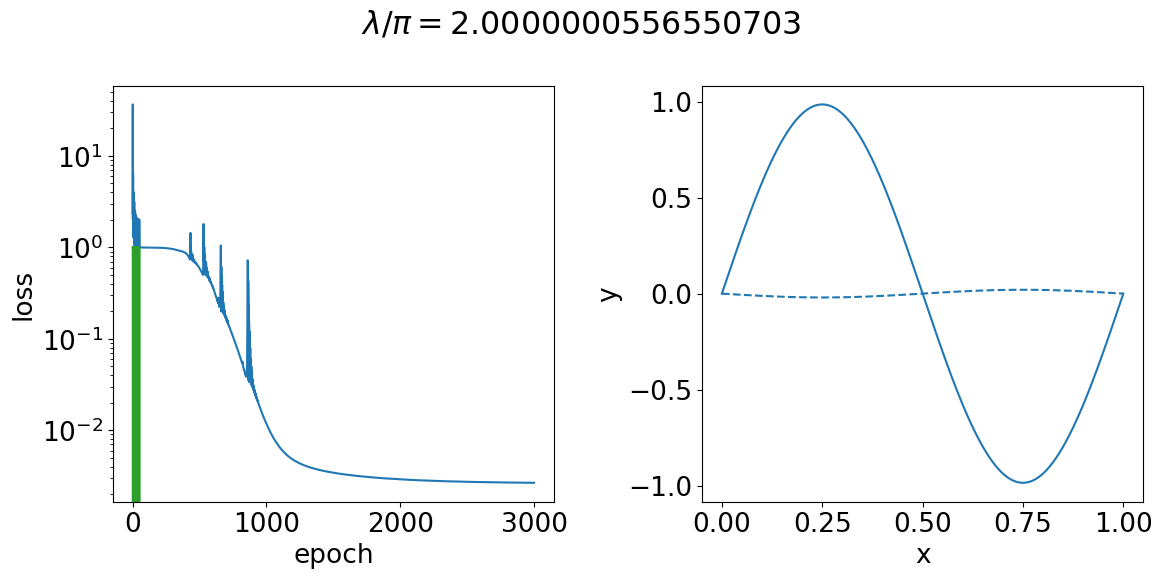

In [ ]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []
regularization_loss_hist = [] #For checking the contribution of the regularization loss.
node_loss_hist = [] # For checking the contribution of the node loss.

optimizer = optim.Adam(ode.parameters(), lr=5e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01)**(1/2000))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

x = torch.tensor(np.linspace(0, 1, 500, dtype = np.float32)).reshape(500, 1)
x.requires_grad = True

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6));
font = {'size'   : 19}
plt.rc('font', **font)
x_vals = np.linspace(0, 1, 100)
c_vals = -0.02*np.sin(2* np.pi * x_vals)
for epoch in range(3001):
    try:
        optimizer.zero_grad()

        loss, node_penalty_term, num_sign_changes_term, regularization_term = odeloss(x)
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())
        regularization_loss_hist.append(regularization_term.item())
        node_loss_hist.append(node_penalty_term.item())

        if epoch % 100 == 0:
            #print(f"Epoch {epoch}, Node Penalty Term: {node_penalty_term.item()}, Sign changes: {num_sign_changes_term.item()}")
            plt.suptitle(f'$\lambda/\pi = {ode.lam.item() / np.pi}$')

            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            ax1.plot(regularization_loss_hist)
            ax1.plot(node_loss_hist)

            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.plot(x.cpu().detach().numpy(), ode(x).cpu().detach().numpy())
            ax2.plot(x_vals, c_vals, color='#1f77b4', linestyle = '--') #Plot for the exact solution of cosine

            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()

    except KeyboardInterrupt:
        break


Finding the fundamental mode is easy.
However the network is having trouble finding higher overtones.

# 1D Wave Equation

Our goal in this section is to use pythorch and physics-informed neural networks to solve a 1D wave equation on a string.

In [ ]:
def node_penalty(f, expected_sign_changes=1):

    # Calculate the sign of f at each point
    sign_f = torch.sign(f)

    # Calculate the difference in sign between consecutive elements
    # A non-zero difference indicates a sign change
    product_consecutive = f[1:] * f[:-1] #If the product of two consecutive numbers is negative, it means that the sign changed. (if the function is oscillating around 0)

    sign_changes =  (product_consecutive < 0).float()



    # Count the number of sign changes (non-zero entries imply a sign change)
    num_sign_changes = torch.sum(sign_changes).float()

    # Calculate the penalty as the squared difference between the observed and expected sign changes
    penalty = (((num_sign_changes - expected_sign_changes) ** 2))/(expected_sign_changes + num_sign_changes+0.001) ** 2

    return penalty, num_sign_changes

def amplitude_regularization(f, target_amplitude):
    # Calculate the deviation of f's peak (or average) amplitude from the target
    amplitude_deviation = torch.abs(torch.max(torch.abs(f)) - target_amplitude)
    return amplitude_deviation**2

class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x):
        f  = self.ode(x)
        d2f = gradients(f, x, 2)
        base_loss = torch.mean((d2f + f*self.ode.lam**2)**2)
        #regularization = torch.mean(torch.abs(f) - 1)**2
        regularization = torch.tensor(0)
        # Node penalty encouraging the presence of a node (zero crossing)
        node_penalty_term , num_sign_changes_term = node_penalty(f)
        amplitude_loss = amplitude_regularization(f,1)
        loss = base_loss + 1*regularization  +  node_penalty_term + amplitude_loss
      #  loss = torch.mean((d2f + f*self.ode.lam**2)**2+ (torch.mean(f) )**2)

        return loss, node_penalty_term, num_sign_changes_term, regularization

In [ ]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 40),  # Space and time arrays as input
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 1),  # Only 1 single function as output
        ) # 1 hidden layer should be enough

        for layer in self.net.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean = 0, std = 0.1)
                nn.init.constant_(layer.bias, val = 0.0) # standard initialization

    def forward(self, x, t):
        input_tensor = torch.cat([x, t], dim=1)
        return self.net(input_tensor)  # We could use force boundary conditions here.

# class ODELoss(nn.Module):
#     def __init__(self, ode):
#         super(ODELoss, self).__init__()
#         self.ode = ode

#     def gaussian_pulse(self, x, mu=0.0, sigma=0.1):
#         return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

#     def forward(self, x, t):

#         f  = self.ode(x,t) # The function that we want to approximate with the NN

#         d2fdx2 = gradients(f, x, 2) # Second space derivative
#         d2fdt2 = gradients(f, t, 2) # Second time derivative

#         # Let's define here the wave equation:
#         wave_equation = -d2fdt2 + d2fdx2  # For simplicity we set c_s = 1

#         # Differential Equation Loss:
#         # Should be 0 for a solution of the eqs.
#         eq_loss = torch.mean(wave_equation**2)
#         # Initial Condition Loss:
#         # Should be 0 for if the initial conditions are satisfied.
#         ic_loss = torch.mean((f[:, 0] - self.gaussian_pulse(x[:, 0])) ** 2)
#         # Boundary Condition Loss:
#         # Should be 0 if the boundary conditions are satisfied.
#         boundary_loss = torch.mean(f[:, :1] ** 2 + f[:, -1:] ** 2)

#         return eq_loss, ic_loss, boundary_loss


In [ ]:
ode = ODE()

In [ ]:
x = torch.tensor([0, 2])
t = torch.tensor([0, 1])
x_grid, t_grid = torch.meshgrid(x, t, indexing='ij')

In [ ]:
print(x_grid)
print(t_grid)

tensor([[0, 0],
        [2, 2]])
tensor([[0, 1],
        [0, 1]])


# Example 2: Heat Equation (Parabolic PDE)

In this section we will move to the study of 2-dimensional equations. We can start with the analysis of a parabolic PDE, in particular we focus on the analysis of the heat equation
$$ \partial_t u = \partial^2_{xx} u.$$
While for ODEs (previous case) we only need to specify boundary conditions (BCs)here we also need to specify initial conditions (ICs)

Let us consider:



*   **BCs:**
$$u(x= \pm 5, t)= 0$$

*   **ICs:**
$$u(x, t=0)= e^{-x^2}$$






# Example 3: Wave Equation (Hyperbolic PDE)

# Example 4: Poisson Equation (Elliptic PDE)